In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Camera Calibration

### Load up the Points

In [2]:
x = np.loadtxt('./data/2Dpoints.txt')

In [3]:
X = np.loadtxt('./data/3Dpoints.txt')

In [4]:
t1 = np.zeros((2*len(X), 4))
t2 = np.zeros((2*len(X), 4))
b = np.zeros((2*len(X), 4))
for i in range(len(X)):
    xi, yi = x[i]
    t1[i*2] = np.hstack((X[i], [1]))
    t2[i*2+1] = np.hstack((X[i], [1]))
    b[i*2] = np.hstack((-xi*X[i], [-xi]))
    b[i*2+1] = np.hstack((-yi*X[i], [-yi]))

### Create the linear system of equations that give us our projection matrix

In [6]:
A = np.hstack((t1, t2, b))

### Solve the system

In [7]:
ew, ev = np.linalg.eig(A.T @ A)

### Get the minimum eigenvector

In [8]:
p = ev[:,np.argmin(ew)]

### Normalize the vector

In [9]:
p /= np.linalg.norm(p)

### Ensure the norm is 1

In [10]:
np.linalg.norm(p)

1.0

### Rasterize our matrix to get camera

In [11]:
p = p.reshape((3, 4))

### Get 2D projections from our 3D points and camera

In [13]:
out_proj = (p @ np.hstack((X, np.ones((len(X),1)))).T).T

In [14]:
out_proj[:,0] = out_proj[:,0] / out_proj[:,2]
out_proj[:,1] = out_proj[:,1] / out_proj[:,2]

In [15]:
out_x, out_y = out_proj[:,0], out_proj[:,1]

In [16]:
in_x, in_y = x[:,0], x[:,1]

### Calculate sum of squared distance

In [17]:
ssqe = np.sum((in_x - out_x)**2 + (in_y - out_y)**2)

In [18]:
print(ssqe)

18.74500374736163


## Homography

### Load the points

`The function gets rid of the annoying error that NumPy's loadtxt() cries about.`

In [49]:
def fileprocess(s):
    im1, im2 = [], []
    with open(s) as file:
        for line in file:
            a, b, c, d = line.split(',')
            im1.append([float(a),float(b)])
            im2.append([float(c),float(d)])
    return im1,im2

In [50]:
img1, img2 = fileprocess('./data/homography.txt')

In [51]:
img1, img2 = np.array(img1), np.array(img2)

### Compute $T^a$ and $T^b$

In [52]:
def computeTransform(img):
    x = img[:,0]
    y = img[:,1]

    T = np.zeros((3,3))
    
    s = np.sqrt(2)/ np.mean(np.sqrt((x-x.mean())**2 + (y-y.mean())**2))
    
    T[0] = np.array([s, 0, -s*x.mean()])
    T[1] = np.array([0, s, -s*y.mean()])
    T[2] = np.array([0, 0, 1])
    
    return T, s

In [53]:
Ta, s1 = computeTransform(img1)

In [54]:
Tb, s2 = computeTransform(img2)

### Normalize Data

In [55]:
def normalize(img, s):
    img2 = np.zeros(img.shape)
    x = img[:,0]
    y = img[:,1]
    x = img[:,0] - img[:,0].mean()
    y = img[:,1] - img[:,1].mean()
    img2[:,0] = s*x
    img2[:,1] = s*y
    
    return img2

In [57]:
img1_n = normalize(img1, s1)
img2_n = normalize(img2, s2)

### Compute $\tilde{H}$

In [61]:
x1 = img1_n[:,0]
y1 = img1_n[:,1]

x2 = img2_n[:,0]
y2 = img2_n[:,1]

In [62]:
ht1 = np.zeros((2*len(x1), 3))
ht2 = np.zeros((2*len(x1), 3))
ht3 = np.zeros((2*len(x1), 3))
for i in range(len(x1)):
    ht1[i*2] = np.hstack((x1[i], y1[i], 1))
    ht2[i*2+1] = np.hstack((x1[i], y1[i], 1))
    ht3[i*2] = np.hstack((-x2[i]*x1[i], -y1[i]*x2[i], -x2[i]))
    ht3[i*2+1] = np.hstack((-y2[i]*x1[i], -y1[i]*y2[i], -y2[i]))

In [63]:
AH_bar = np.hstack((ht1, ht2, ht3))

In [64]:
ew2, ev2 = np.linalg.eig(AH_bar.T @ AH_bar)

In [65]:
H_bar = ev2[:,np.argmin(ew2)]

In [66]:
H_bar /= np.linalg.norm(H_bar)

In [67]:
np.linalg.norm(H_bar)

1.0

In [68]:
H_bar = H_bar.reshape((3,3))

### Compute $H$

In [70]:
H = np.linalg.inv(Tb).dot(H_bar).dot(Ta)

### Compute points from image 1 using our $H$

In [73]:
img2_proj = (H.dot(np.hstack((img1, np.ones((len(img1),1)))).T)).T

In [75]:
img2_proj[:,0] = img2_proj[:,0]/img2_proj[:,2]
img2_proj[:,1] = img2_proj[:,1]/img2_proj[:,2]

### Plot computed points

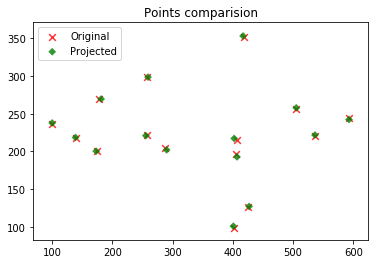

In [89]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(img2[:,0], img2[:,1], alpha=0.8, c='red', edgecolors='none', s=45, label='Original', marker='x')
ax.scatter(img2_proj[:,0], img2_proj[:,1], alpha=0.8, c='green', edgecolors='none', s=30, label='Projected', marker='D')
#ax.scatter(solnmx[:,0], solnmx[:,1], alpha=0.8, c='green', edgecolors='none', s=30, label='Projected')
plt.title('Points comparision')
plt.legend(loc=2)
plt.show()

### Compute sum of squared error

In [77]:
orig_x = img2[:,0]
orig_y = img2[:,1]

proj_x = img2_proj[:,0]
#proj_x = solnmx[:,0]
proj_y = img2_proj[:,1]
#proj_y = solnmx[:,1]

ssqe2 = np.sum((orig_x - proj_x)**2 + (orig_y - proj_y)**2)

In [78]:
print(ssqe2)

105.97387926939311
